#### Neural network using FLAX

In [8]:
import jax 
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import torch
from scipy.spatial import cKDTree
import optax
from flax import nnx
from optax import adam
from tqdm.notebook import tqdm # progress bar
import matplotlib.pyplot as plt

In [1]:
%run Data_sampling.ipynb

In [2]:
# NOTE: To jit nnx modules use @nnx.jit


In [3]:
# TODO: Get flax and optax up and running in the environment
# TODO: Use a predefined loss function from optax
# TODO: Use ADAM optimizer in FLAX model
# TODO: Find out if we need to create a train_step and train_epoch function.
#       - Create them if they are needed
# TODO: Rewrite PCDiff to work in jax - should be relatively easy :)


### Creating training and test data

In [4]:
data = data_to_neighborhood(50)

Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from ./Data/Full_point_clouds\cube-isometric.xyz
Loaded 35947 points from ./Data/Full_point_clouds\bunny_order3_normal_beta.txt
Loaded 120982 points from .

In [21]:
print(data)

[[-2.82879592e-03  2.91379415e-01 -2.47455306e-01  8.39726705e-01
   4.03000000e-02]
 [ 2.59772347e-01  5.61000462e-01 -6.98101837e-02  9.09222925e-01
   3.61950000e-02]
 [-4.67583673e-02  8.43376995e-01  2.18904959e-01  7.34415275e-01
   3.87060000e-02]
 ...
 [-6.00460204e-02  1.27328094e-01  1.29962706e+00  3.23212339e+01
   3.04260000e-02]
 [ 3.40816327e-06  1.22301708e-09 -2.97306735e-02  1.66660376e-02
   3.35280000e-02]
 [-1.61224490e-06  8.06972095e-10 -8.11153061e-03  1.74836894e-02
   3.35280000e-02]]


In [6]:
from sklearn.model_selection import train_test_split    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = data[:,:-1]
y = data[:,-1]

pipeline = Pipeline([
    ('scaler', StandardScaler())  # Standardization: Mean 0, Std 1
])

# Perform the train-test split using Scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on training data & transform both train and test sets
X_train = pipeline.fit_transform(X_train)  # Fit & transform training set
X_test = pipeline.transform(X_test)        # Only transform test set (no fitting to avoid leakage)


X_train.shape, X_test.shape
y_test.shape, y_train.shape

# # Convert back to JAX arrays for Flax/NnX
# X_train = jnp.array(X_train)
# X_test = jnp.array(X_test)
# y_train = jnp.array(y_train)
# y_test = jnp.array(y_test)



((500,), (2000,))

In [9]:
from flax import nnx
import jax.numpy as jnp
from jax import random

class SimpleGradientModel(nnx.Module):
    def __init__(self, rngs):
        # Initialize layers with rngs (random keys)
        self.dense1 = nnx.Linear(4, 32, rngs=rngs)
        self.dense2 = nnx.Linear(32, 64,  rngs=rngs)
        self.dense3 = nnx.Linear(64, 32, rngs=rngs)
        self.dense4 = nnx.Linear(32, 1, rngs=rngs)

    def __call__(self, x):
        x = self.dense1(x)
        x = nnx.tanh(x)
        x = self.dense2(x)
        x = nnx.tanh(x)
        x = self.dense3(x)
        x = nnx.tanh(x)
        x = self.dense4(x)  # Output layer (no activation for regression)
        return x

# Example usage
key = random.PRNGKey(0)
x_sample = random.normal(key, (10, 4))  # Batch of 10 samples, each with 4 features

# Initialize model
model = SimpleGradientModel(rngs=nnx.Rngs(0))  # Now passes PRNG keys correctly

# Define the optimizer
lr = 0.1 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer





In [10]:
# MSE loss
@nnx.jit
def loss_fn(model, x, y_target):
    y_pred = model(x)
    return optax.losses.squared_error(predictions=y_pred, targets=y).mean()


@nnx.jit # jit with automatic handling of nnx objects as parameters
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y) # get loss and gradients using JAX autodiff
  optimizer.update(grads) # update parameters of the model according to the optimizer
  return loss



# Train for a single epoch
def train_epoch(model, optimizer, xs_train, ys_train, xs_test, ys_test, batch_size, rng):
    train_ds_size = len(xs_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, len(xs_train)) # shuffle dataset (permutation of samples order)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_xs = xs_train[perm, :]
        batch_ys = ys_train[perm, :]
        loss = train_step(model, optimizer, batch_xs, batch_ys)
        epoch_loss.append(loss) # store training loss for the current batch

    train_loss = np.mean(epoch_loss)
    test_loss = loss_fn(model, xs_test, ys_test)
    return model, train_loss, test_loss

In [11]:
# Define the optimizer
lr = 0.1 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer

# MSE loss
@nnx.jit
def loss_fn(model, x, y_target):
   y_pred = model(x)
   return ((y_pred - y_target) ** 2).mean()
   # You can also use losses already implemented in optax
   # return optax.losses.squared_error(predictions=y_pred, targets=y).mean()

# Training step (= one batch evaluation/params update)
@nnx.jit # jit with automatic handling of nnx objects as parameters
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y) # get loss and gradients using JAX autodiff
  optimizer.update(grads) # update parameters of the model according to the optimizer
  return loss

# Train for a single epoch
def train_epoch(model, optimizer, xs_train, ys_train, xs_test, ys_test, batch_size, rng):
  train_ds_size = len(xs_train)
  steps_per_epoch = train_ds_size // batch_size

  perms = random.permutation(rng, len(xs_train)) # shuffle dataset (permutation of samples order)
  perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []

  for perm in perms:
    batch_xs = xs_train[perm, :]
    batch_ys = ys_train[perm, :]
    loss = train_step(model, optimizer, batch_xs, batch_ys)
    epoch_loss.append(loss) # store training loss for the current batch

  train_loss = np.mean(epoch_loss)
  test_loss = loss_fn(model, xs_test, ys_test)
  return model, train_loss, test_loss

In [12]:
epochs = 50
log_period_epoch = 10
batch_size = 32

train_loss_history = []
val_loss_history = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model, train_loss, validation_loss = train_epoch(model, optimizer, X_train,
                                                      y_train, X_test, y_test,
                                                    batch_size, random.key(1))

    train_loss_history.append(train_loss)
    val_loss_history.append(validation_loss)

    if epoch == 1 or epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, training loss = {train_loss}, test loss = {validation_loss}')

  0%|          | 0/50 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

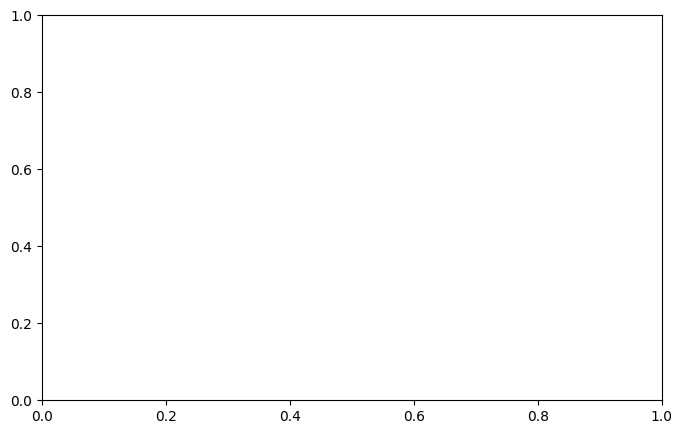

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss', marker='o')



plt.xlabel("Epochs")
plt.ylabel("Loss (Log Scale)")
plt.title("Loss vs. Epochs (Log Scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

### Another model with MLP-Regressor

In [14]:
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import logging
from matplotlib.pyplot import plot

In [15]:
# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, x, y):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer.update(grads)
    return loss

def _train_epoch(
    model, optimizer, xs_train, ys_train, batch_size, rng
):
    train_ds_size = len(xs_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, len(xs_train))
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_xs = xs_train[perm, :]
        batch_ys = ys_train[perm, :]
        loss = train_step(model, optimizer, batch_xs, batch_ys)
        epoch_loss.append(loss)  # store training loss for the current batch

    train_loss = np.mean(epoch_loss)
    return model, train_loss


def train(model, optimizer, xs_train, ys_train,
          batch_size,epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        model, train_loss = _train_epoch(
            model, optimizer, xs_train, ys_train,
            batch_size, random.key(1),
        )

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

In [16]:
# adapted from template https://github.com/scikit-learn-contrib/project-template/blob/main/skltemplate/_template.py

class MLPRegressor(BaseEstimator):

    def __init__(self, model, lr, epochs, batch_size, log_period_epoch=10,
                 show_progress=True):
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_period_epoch = log_period_epoch
        self.show_progress = show_progress

    def fit(self, X, y):
        # `_validate_data` is defined in the `BaseEstimator` class.
        # It allows to:
        # - run different checks on the input data;
        # - define some attributes associated to the input data: `n_features_in_` and
        #   `feature_names_in_`.
        X, y = self._validate_data(X, y, accept_sparse=True)

        # transform row vectors into columns to be compatible with the output of the NN
        y = y.reshape(-1, 1)

        self._optimizer = nnx.Optimizer(self.model, optax.adam(self.lr))

        self.train_loss_history = train(self.model, self._optimizer, X, y,
                                        self.batch_size, self.epochs,
                                        self.log_period_epoch, self.show_progress)

        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        # Check if fit had been called
        check_is_fitted(self)
        X = self._validate_data(X, accept_sparse=True, reset=False)
        return self.model(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)    


In [17]:

m = MLPRegressor(model, 0.01, 500, 32)

In [18]:
m.fit(X_train, y_train)

  0%|          | 0/500 [00:00<?, ?it/s]

MLPRegressor(batch_size=32, epochs=500, lr=0.01,
             model=SimpleGradientModel( # Param: 4,385 (17.5 KB)
  dense1=Linear( # Param: 160 (640 B)
    bias=Param( # 32 (128 B)
      value=Array(shape=(32,), dtype=dtype('float32'))
    ),
    bias_init=<function zeros at 0x000002BF33556D40>,
    dot_general=<function dot_general at 0x000002BF33029300>,
    dtype=None,
    in_features=4,
    kernel=Param( # 128 (512 B)
      value=Array...
      value=Array([0.07358682], dtype=float32)
    ),
    bias_init=<function zeros at 0x000002BF33556D40>,
    dot_general=<function dot_general at 0x000002BF33029300>,
    dtype=None,
    in_features=32,
    kernel=Param( # 32 (128 B)
      value=Array(shape=(32, 1), dtype=dtype('float32'))
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x000002BF441E6020>,
    out_features=1,
    param_dtype=float32,
    precision=None,
    use_bias=True
  )
))

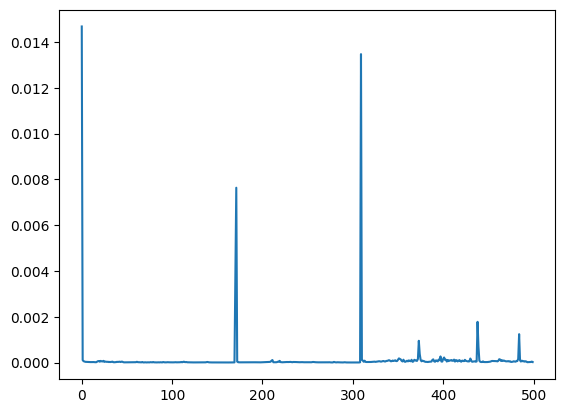

In [19]:
plt.plot(m.train_loss_history)

In [20]:
print("R2 for train set:", m.score(X_train, y_train))
print("R2 for test set:", m.score(X_test, y_test))

R2 for train set: -0.3055272592502183
R2 for test set: -0.4454297314093947
